In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout,Input,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import model_from_json
import json

# preparing model

In [26]:
import os

dataset_dir = 'dataset'
train_dir = 'dataset/train'
test_dir = 'dataset/test'

BATCH_SIZE = 32
categories = ['real','spoof']

def get_size_dataset(dir):
    for category in categories:
        path = os.path.join(dir,category)
        if category == 'real':
            r1 = len(os.listdir(path))
        else:
            s1 = len(os.listdir(path))
            
    return r1 + s1

In [27]:
train_datagen = ImageDataGenerator(brightness_range=(0.8,1.2), rotation_range=30, width_shift_range=0.2,
                                    height_shift_range=0.2, fill_mode='nearest', shear_range=0.2, 
                                    zoom_range=0.3, rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,target_size=(160,160),color_mode='rgb',
                                                    class_mode='binary',batch_size=BATCH_SIZE,shuffle=True)
valid_generator = valid_datagen.flow_from_directory(test_dir,target_size=(160,160),color_mode='rgb',
                                                    class_mode='binary',batch_size=BATCH_SIZE)

train_sz = get_size_dataset(train_dir)
valid_sz = get_size_dataset(test_dir)

### model selection and transfer learning

In [30]:
mobilenet = MobileNetV2(weights="imagenet",include_top=False,input_tensor=Input(shape=(160,160,3)))

2022-11-22 16:41:03.258877: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-11-22 16:41:03.821824: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-22 16:41:03.821906: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (l4mb0-PC): /proc/driver/nvidia/version does not exist
2022-11-22 16:41:03.822773: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


9412608/9406464 [==============================] - 3s 0us/step


In [31]:
mobilenet.trainable = False

In [32]:
output = Flatten()(mobilenet.output)
output = Dropout(0.3)(output)
output = Dense(units = 8,activation='relu')(output)
prediction = Dense(1,activation='sigmoid')(output)

In [33]:
model = Model(inputs = mobilenet.input,outputs = prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

### compiling

In [45]:
model.compile(
  loss='binary_crossentropy',
  optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.000001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
),
  metrics=['accuracy']
)

In [46]:
import os
folder = "model_weights/"
if(not os.path.exists(folder)): os.mkdir(folder)

model_checkpoint = ModelCheckpoint('./model_weights/finalyearproject_antispoofing_model_{epoch:02d}-{val_accuracy:.6f}.h5', 
                                   monitor='val_loss', mode='min', verbose=1, save_best_only=True,save_weights_only=True)

In [47]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // 25,
    validation_data = valid_generator, 
    validation_steps = valid_generator.samples // 25,
    epochs = 100,
    callbacks=[model_checkpoint],
    workers = 10)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-11-22 16:44:43.662502: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-22 16:44:43.682097: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2894590000 Hz


168/168 [==============================] - ETA: 0s - loss: 0.8444 - accuracy: 0.5514WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f3f35017af0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
168/168 [==============================] - 39s 213ms/step - loss: 0.8444 - accura

168/168 [==============================] - 33s 198ms/step - loss: 0.3118 - accuracy: 0.8605 - val_loss: 0.2024 - val_accuracy: 0.9253

Epoch 00026: val_loss improved from 0.21163 to 0.20245, saving model to ./model_weights/finalyearproject_antispoofing_model_26-0.925263.h5
Epoch 27/100
168/168 [==============================] - 34s 199ms/step - loss: 0.2953 - accuracy: 0.8679 - val_loss: 0.2020 - val_accuracy: 0.9221

Epoch 00027: val_loss improved from 0.20245 to 0.20204, saving model to ./model_weights/finalyearproject_antispoofing_model_27-0.922105.h5
Epoch 28/100
168/168 [==============================] - 33s 199ms/step - loss: 0.2927 - accuracy: 0.8744 - val_loss: 0.1901 - val_accuracy: 0.9316

Epoch 00028: val_loss improved from 0.20204 to 0.19006, saving model to ./model_weights/finalyearproject_antispoofing_model_28-0.931579.h5
Epoch 29/100
168/168 [==============================] - 34s 199ms/step - loss: 0.2904 - accuracy: 0.8744 - val_loss: 0.1866 - val_accuracy: 0.9284

Epoc

168/168 [==============================] - 33s 195ms/step - loss: 0.1689 - accuracy: 0.9297 - val_loss: 0.1117 - val_accuracy: 0.9653

Epoch 00056: val_loss did not improve from 0.11124
Epoch 57/100
168/168 [==============================] - 32s 191ms/step - loss: 0.1674 - accuracy: 0.9352 - val_loss: 0.1075 - val_accuracy: 0.9663

Epoch 00057: val_loss improved from 0.11124 to 0.10748, saving model to ./model_weights/finalyearproject_antispoofing_model_57-0.966316.h5
Epoch 58/100
168/168 [==============================] - 33s 196ms/step - loss: 0.1674 - accuracy: 0.9330 - val_loss: 0.1032 - val_accuracy: 0.9695

Epoch 00058: val_loss improved from 0.10748 to 0.10316, saving model to ./model_weights/finalyearproject_antispoofing_model_58-0.969474.h5
Epoch 59/100
168/168 [==============================] - 33s 194ms/step - loss: 0.1641 - accuracy: 0.9325 - val_loss: 0.1048 - val_accuracy: 0.9674

Epoch 00059: val_loss did not improve from 0.10316
Epoch 60/100
168/168 [===================

168/168 [==============================] - 33s 194ms/step - loss: 0.1137 - accuracy: 0.9590 - val_loss: 0.0659 - val_accuracy: 0.9779

Epoch 00090: val_loss improved from 0.06672 to 0.06590, saving model to ./model_weights/finalyearproject_antispoofing_model_90-0.977895.h5
Epoch 91/100
168/168 [==============================] - 32s 193ms/step - loss: 0.1187 - accuracy: 0.9569 - val_loss: 0.0682 - val_accuracy: 0.9768

Epoch 00091: val_loss did not improve from 0.06590
Epoch 92/100
168/168 [==============================] - 33s 194ms/step - loss: 0.1132 - accuracy: 0.9561 - val_loss: 0.0612 - val_accuracy: 0.9779

Epoch 00092: val_loss improved from 0.06590 to 0.06118, saving model to ./model_weights/finalyearproject_antispoofing_model_92-0.977895.h5
Epoch 93/100
168/168 [==============================] - 32s 193ms/step - loss: 0.1196 - accuracy: 0.9502 - val_loss: 0.0636 - val_accuracy: 0.9789

Epoch 00093: val_loss did not improve from 0.06118
Epoch 94/100
168/168 [===================

In [48]:
model_json = model.to_json()
with open("antispoofing_models/antispoofing_model.json", "w") as json_file:
    json_file.write(model_json)

/home/l4mb0/.local/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


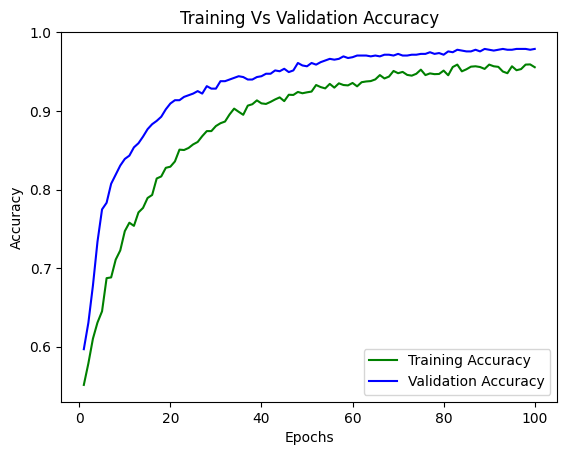

In [49]:
import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1,101)
plt.plot(epochs,train_accuracy,'g',label='Training Accuracy')
plt.plot(epochs,validation_accuracy,'b',label='Validation Accuracy')
plt.title('Training Vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

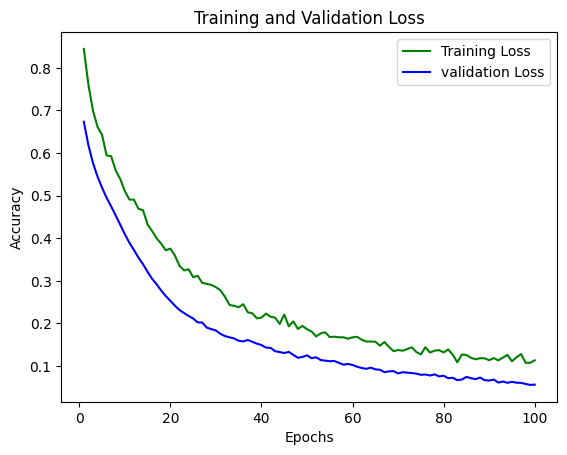

In [50]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,101)
plt.plot(epochs,train_loss,'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [52]:
from tensorflow.keras.preprocessing import image
import numpy as np
def check_fakes(path,category_type):
    predictor = {}
    path= os.path.join(path,category_type)
    for img in os.listdir(path):
        try:
            img = image.load_img(os.path.join(path,img),target_size=(160,160))
            img = image.img_to_array(img)
            img = np.expand_dims(img,axis=0)
            img = img / 255.0
            prediction = model.predict(img)
            if prediction > 0.5:
                prediction_class = 1
            else:
                prediction_class = 0
            result = categories[prediction_class]
            if result not in predictor:
                predictor[result] = 1
            else:
                predictor[result] += 1
        except Exception as e:
            pass
    return predictor

In [53]:
check_fakes(test_dir,categories[1])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


{'spoof': 461, 'real': 13}

In [54]:
check_fakes(test_dir,categories[0])

{'real': 470, 'spoof': 7}